 Your spectra have been computed! 😎 
 Your therml spectra have been computed! 🔥 


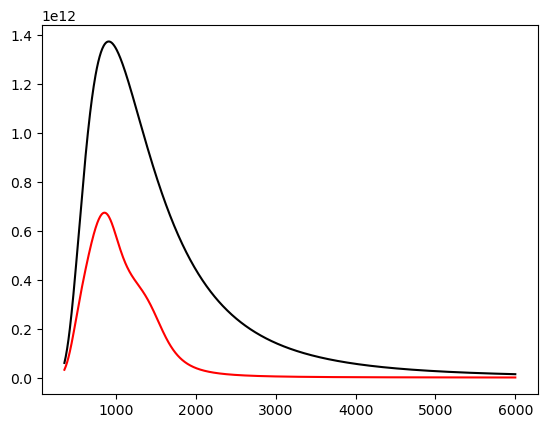

In [13]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np

test_args = {
    "wavelength_list": [350e-9, 6000e-9, 1000],
    "Material_List": ["Air",  "W", "Air"],
    "Thickness_List": [0, 900e-9, 0],
    "temperature": 3200,
    "therml": True
}


sf = wptherml.SpectrumFactory()
test = sf.spectrum_factory('Tmm', test_args)


plt.plot(test.wavelength_array * 1e9, test.thermal_emission_array, 'red')
plt.plot(test.wavelength_array * 1e9, test.blackbody_spectrum, 'black')
plt.show()

In [14]:
x_bb, y_bb, z_bb = test.compute_cie(test.blackbody_spectrum)
x_w, y_w, z_w = test.compute_cie(test.thermal_emission_array)

In [15]:
print(x_bb, y_bb, z_bb)
print(x_bb + y_bb + z_bb)

0.42332513259669524 0.3989496663034545 0.17772520109985018
1.0


In [16]:
print(x_w, y_w, z_w)

0.416854912443237 0.3967800988924877 0.18636498866427517


In [17]:
xp, yp, zp = test.compute_planckian_locus()

In [18]:
print(xp, yp, zp)

0.42318180676269535 0.3990776851656569 0.17774050807164776


4000.0


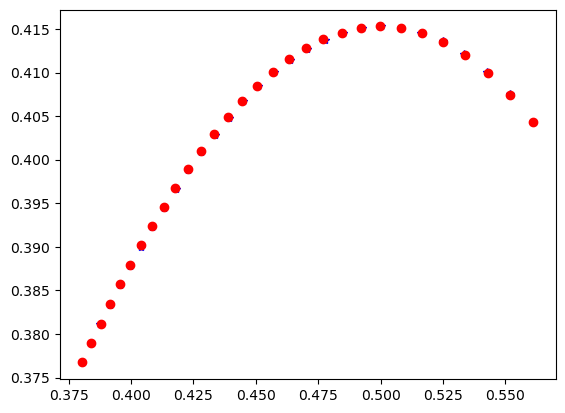

[0.5610412401396822, 0.5516355274132175, 0.5424510757236142, 0.5334948689123025, 0.524773244017467, 0.5162915642063702, 0.5080540019052908, 0.5000634204618598, 0.4923213376034353, 0.48482795262228995, 0.4775822201112562, 0.4705819551438362, 0.46382395734794346, 0.4573041439308794, 0.45101768412763316, 0.4449591296426829, 0.43912253739496043, 0.4335015822628263, 0.4280896585935634, 0.4228799700349224, 0.41786560781250204, 0.41303961796182304, 0.4083950582685294, 0.40392504580874544, 0.3996227960426577, 0.39548165442051875, 0.3914951214291133, 0.3876568719517082, 0.38396076974555626, 0.38040087776536186]
[0.5609411935680847, 0.5519215447804444, 0.5428485812842194, 0.5338452354077586, 0.5249946970255611, 0.5163521397295389, 0.5079528950398745, 0.49981820662740495, 0.49195931540123305, 0.48438038052448973, 0.477080580457375, 0.4700556312184053, 0.4632988871210534, 0.4568021402585134, 0.4505562012811185, 0.44455132054824753, 0.4387774922594726, 0.43322467249630947, 0.42788293376830355, 0.42

In [29]:
# Let's test our CIE calculator against the Planckian locus calculation
T_list = np.linspace(1700, 4000, 30)

pl_x = []
pl_y = []

n_x = []
n_y = []
for temp in T_list:
    test.temperature = temp
    test._compute_therml_spectrum(test.wavelength_array, test.emissivity_array)
    x_bb, y_bb, z_bb = test.compute_cie(test.blackbody_spectrum)
    pl_x.append(x_bb)
    pl_y.append(y_bb)
    x_p, y_p, z_p = test.compute_planckian_locus()
    n_x.append(x_p)
    n_y.append(y_p)

    
print(test.temperature)

plt.plot(pl_x, pl_y, 'b*')
plt.plot(n_x, n_y, 'ro')
plt.show()

print(pl_x)
print(n_x)

(300.0, 800.0)

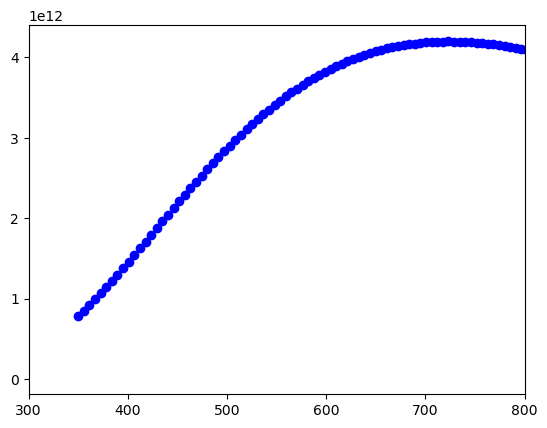

In [30]:
plt.plot(test.wavelength_array*1e9, test.blackbody_spectrum, 'bo')
plt.xlim(300,800)